<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: MIRI LRS Slitless

## Spec2: Extract1d()
<span style="color:red"> **Instruments Affected**</span>: MIRI

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)

<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.

* os, glob for general  OS operations
* numpy
* astropy.io for opening fits files
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot to generate plot
* json for editing json files
* crds for retrieving reference files as needed
* ci_watson for data retrieval from artifactory
* scipy.interpolate
* gwcs.wcstools for retrieving the bounding box



[Top of Page](#title_ID)

In [2]:
import numpy as np
from numpy.testing import assert_allclose
import os
from glob import glob
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d

import astropy.io.fits as fits
import astropy.units as u
import jwst.datamodels as datamodels
from jwst.datamodels import RampModel, ImageModel
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline
from jwst.extract_1d import Extract1dStep
from gwcs.wcstools import grid_from_bounding_box
from jwst.associations.asn_from_list import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase


import json
import crds

from ci_watson.artifactory_helpers import get_bigdata

%matplotlib inline

2021-04-02 19:31:01,576 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/photutils/detection/findstars.py:33: AstropyDeprecationWarning: _StarFinderKernel was moved to the photutils.detection._utils module. Please update your import statement.
  warnings.warn(f'{name} was moved to the {deprecated[name]} module. '



<a id="intro_ID"></a>
# Introduction


In this notebook we will test the **extract1d()** step of Spec2Pipeline() for **LRS slitless** observations. LRS slitless observations are always time series observations.

Step description: https://jwst-pipeline.readthedocs.io/en/stable/jwst/extract_1d/index.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/extract_1d

### Short description of the algorithm

Slitless observations are not nodded. The algorithm in its default settings centres on the source and extracts using a fixed-width aperture. The default aperture is 11 pixels wide.

[Top of Page](#title_ID)

<a id="data_ID"></a>
# Loading Data

We are using here a simulated LRS slit observation, generated with MIRISim v2.3.0 (as of Dec 2020). It is a simple time series observation modelled on a known exoplanet host, using ngroups=100 and nints=10.

We retrieve the data from artifactory.


[Top of Page](#title_ID)

In [3]:
Slitlessfile = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_tso3',
                                    'tso3_miri_test',
                                    'pipetest_miri_lrs_tso_100G10I.fits')

det1_configfile = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_tso3',
                                    'tso3_miri_test',
                                    'calwebb_tso1.cfg')

spec2_configfile = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_tso3',
                                    'tso3_miri_test',
                                    'calwebb_tso-spec2.cfg')



Collect configuration files locally if they aren't yet there.

In [4]:
#if not os.path.exists('../cfg_files/'):
#    os.mkdir('../cfg_files/')
#    cfgs = collect_pipeline_cfgs.collect_pipeline_cfgs(dst='../cfg_files/')

<a id="pipeline_ID"></a>
# Run JWST Pipeline

First we run the data through the Detector1() pipeline to convert the raw counts into slopes. This should use the calwebb_tso1.cfg file. The output of this stage will then be run through the Spec2Pipeline. Extract_1d is the final step of this pipeline stage, so we will just run through the whole pipeline, explicitly also saving the Photom() step output for comparison.

[Top of Page](#title_ID)

### Detector1Pipeline

In [5]:
det1 = Detector1Pipeline.call(Slitlessfile, config_file=det1_configfile, save_results=True)
rifile = glob('*tso*_rateints.fits')
print(rifile)

det1_ints = datamodels.open(rifile[0])

2021-04-02 19:31:05,447 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0002.asdf


2021-04-02 19:31:05,453 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/io/fits/hdu/hdulist.py:1187: VerifyWarning: Error validating header for HDU #0 (note: Astropy uses zero-based indexing).
    Header size is not multiple of 2880: 478
There may be extra bytes after the last HDU or the file is corrupted.
  warnings.warn(



2021-04-02 19:31:05,463 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-04-02 19:31:05,464 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-04-02 19:31:05,465 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-04-02 19:31:05,466 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-04-02 19:31:05,466 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-04-02 19:31:05,467 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-04-02 19:31:05,468 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-04-02 19:31:05,469 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-04-02 19:31:05,470 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-04-02 19:31:05,471 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-04-02 19:31:05,472 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-04-02 19:31:05,473 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-04-02 19:31:05,474 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-04-02 19:31:05,475 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-04-02 19:31:05,476 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-04-02 19:31:05,477 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-04-02 19:31:05,478 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-04-02 19:31:05,576 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpjmm9au9z/pipetest_miri_lrs_tso_100G10I.fits',).


2021-04-02 19:31:05,585 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': True, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output

2021-04-02 19:31:05,759 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'pipetest_miri_lrs_tso_100G10I.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'saturation', 'superbias']


2021-04-02 19:31:05,763 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0048.fits'.


2021-04-02 19:31:05,764 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-04-02 19:31:05,765 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-04-02 19:31:05,766 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-04-02 19:31:05,767 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0070.fits'.


2021-04-02 19:31:05,768 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2021-04-02 19:31:05,768 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0043.fits'.


2021-04-02 19:31:05,770 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-04-02 19:31:05,771 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-04-02 19:31:05,771 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-04-02 19:31:06,036 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-02 19:31:06,038 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpjmm9au9z'}


2021-04-02 19:31:06,223 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-04-02 19:31:06,223 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-04-02 19:31:06,224 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-04-02 19:31:06,301 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-02 19:31:06,302 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpjmm9au9z'}


2021-04-02 19:31:06,318 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-04-02 19:31:06,558 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2021-04-02 19:31:06,563 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-04-02 19:31:06,660 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-02 19:31:06,662 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpjmm9au9z'}


2021-04-02 19:31:06,677 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-04-02 19:31:06,890 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2021-04-02 19:31:07,121 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-04-02 19:31:07,132 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-04-02 19:31:07,135 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-04-02 19:31:07,237 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-02 19:31:07,238 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpjmm9au9z'}


2021-04-02 19:31:07,239 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-04-02 19:31:07,239 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-04-02 19:31:07,297 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-02 19:31:07,298 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpjmm9au9z'}


2021-04-02 19:31:07,299 - stpipe.Detector1Pipeline.firstframe - INFO - Step skipped.


2021-04-02 19:31:07,299 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-04-02 19:31:07,351 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-02 19:31:07,353 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpjmm9au9z'}


2021-04-02 19:31:07,353 - stpipe.Detector1Pipeline.lastframe - INFO - Step skipped.


2021-04-02 19:31:07,354 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-04-02 19:31:07,406 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-02 19:31:07,407 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpjmm9au9z'}


2021-04-02 19:31:07,423 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0043.fits


2021-04-02 19:31:07,448 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESET_LARGE does not correspond to an existing DQ mnemonic, so will be ignored


2021-04-02 19:31:07,658 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-04-02 19:31:07,751 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-02 19:31:07,752 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpjmm9au9z'}


2021-04-02 19:31:07,768 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-04-02 19:31:08,010 - stpipe.Detector1Pipeline.linearity - INFO - Extracting linearity subarray to match science data


2021-04-02 19:31:08,241 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-04-02 19:31:08,327 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-02 19:31:08,329 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpjmm9au9z', 'type': 'baseline'}


2021-04-02 19:31:08,329 - stpipe.Detector1Pipeline.rscd - INFO - Step skipped.


2021-04-02 19:31:08,330 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-04-02 19:31:08,388 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-02 19:31:08,389 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpjmm9au9z', 'dark_output': None}


2021-04-02 19:31:08,405 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0048.fits


2021-04-02 19:31:08,711 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=10, ngroups=100, nframes=1, groupgap=0


2021-04-02 19:31:08,712 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=1000, nframes=1, groupgap=0


2021-04-02 19:31:08,992 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-04-02 19:31:09,119 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-02 19:31:09,120 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpjmm9au9z', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-04-02 19:31:09,127 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2021-04-02 19:31:09,127 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2021-04-02 19:31:09,128 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2021-04-02 19:31:09,128 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


2021-04-02 19:31:09,128 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2021-04-02 19:31:09,325 - stpipe.Detector1Pipeline.refpix - WARNING - Refpix correction skipped for MIRI subarrays


2021-04-02 19:31:09,326 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-04-02 19:31:09,409 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-02 19:31:09,410 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpjmm9au9z', 'rejection_threshold': 4.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}


2021-04-02 19:31:09,417 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-04-02 19:31:09,426 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-04-02 19:31:09,444 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0070.fits


2021-04-02 19:31:09,454 - stpipe.Detector1Pipeline.jump - INFO - Found 32 possible cores to use for jump detection 


2021-04-02 19:31:09,630 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2021-04-02 19:31:09,718 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-04-02 19:31:10,014 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-04-02 19:31:10,119 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3290 pixels with at least one CR


2021-04-02 19:31:10,307 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-04-02 19:31:10,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3335 pixels with at least one CR


2021-04-02 19:31:10,616 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-04-02 19:31:10,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3362 pixels with at least one CR


2021-04-02 19:31:10,913 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-04-02 19:31:11,016 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3353 pixels with at least one CR


2021-04-02 19:31:11,201 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 5:


2021-04-02 19:31:11,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3296 pixels with at least one CR


2021-04-02 19:31:11,488 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 6:


2021-04-02 19:31:11,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3315 pixels with at least one CR


2021-04-02 19:31:11,776 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 7:


2021-04-02 19:31:11,879 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3295 pixels with at least one CR


2021-04-02 19:31:12,061 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 8:


2021-04-02 19:31:12,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3284 pixels with at least one CR


2021-04-02 19:31:12,347 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 9:


2021-04-02 19:31:12,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3285 pixels with at least one CR


2021-04-02 19:31:12,634 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 10:


2021-04-02 19:31:12,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3317 pixels with at least one CR


2021-04-02 19:31:12,927 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 3.20877 sec


2021-04-02 19:31:12,929 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 3.512410


2021-04-02 19:31:12,931 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-04-02 19:31:13,199 - stpipe.Detector1Pipeline - INFO - Saved model in pipetest_miri_lrs_tso_100G10I_ramp.fits


2021-04-02 19:31:13,297 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I_ramp.fits>,).


2021-04-02 19:31:13,298 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpjmm9au9z', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-04-02 19:31:13,322 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0070.fits


2021-04-02 19:31:13,331 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-04-02 19:31:13,340 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-04-02 19:31:13,340 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-04-02 19:31:13,341 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2021-04-02 19:31:13,413 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 0


2021-04-02 19:32:19,655 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 100


2021-04-02 19:32:19,657 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 10


2021-04-02 19:32:19,675 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-04-02 19:32:19,786 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(416, 72) from pipetest_miri_lrs_tso_100G10I_ramp.fits>,).


2021-04-02 19:32:19,787 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpjmm9au9z'}


2021-04-02 19:32:19,813 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-04-02 19:32:19,814 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-04-02 19:32:19,815 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-04-02 19:32:19,881 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_ramp.fits>,).


2021-04-02 19:32:19,882 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpjmm9au9z'}


2021-04-02 19:32:19,905 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-04-02 19:32:19,905 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-04-02 19:32:19,906 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-04-02 19:32:19,947 - stpipe.Detector1Pipeline - INFO - Saved model in pipetest_miri_lrs_tso_100G10I_rateints.fits


2021-04-02 19:32:19,947 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-04-02 19:32:19,978 - stpipe.Detector1Pipeline - INFO - Saved model in pipetest_miri_lrs_tso_100G10I_rate.fits


2021-04-02 19:32:19,979 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


['pipetest_miri_lrs_tso_100G10I_rateints.fits']


### Spec2Pipeline

Next we go ahead to the Spec2 pipeline. First we run the Spec2Pipeline() **skipping** the extract1d() step. Then we run the extract_1d() step separately and examine the output. We will run the step with default parameters.


In [6]:
#pipe2 = Spec2Pipeline()
#pipe2.extract_1d.skip = True
#pipe2.photom.save_results = True

#sp2 = pipe2(det1_ints)

sp2 = Spec2Pipeline.call(det1_ints,save_results=True, config_file=spec2_configfile, steps={"extract_1d": {"skip": True}})
print(sp2)



2021-04-02 19:32:20,014 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



2021-04-02 19:32:20,167 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-spec2pipeline_0001.asdf


2021-04-02 19:32:20,173 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/io/fits/hdu/hdulist.py:1187: VerifyWarning: Error validating header for HDU #0 (note: Astropy uses zero-based indexing).
    Header size is not multiple of 2880: 586
There may be extra bytes after the last HDU or the file is corrupted.
  warnings.warn(



2021-04-02 19:32:20,184 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-04-02 19:32:20,185 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-04-02 19:32:20,187 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-04-02 19:32:20,187 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-04-02 19:32:20,188 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-04-02 19:32:20,189 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-04-02 19:32:20,192 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-04-02 19:32:20,193 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-04-02 19:32:20,194 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-04-02 19:32:20,195 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-04-02 19:32:20,196 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-04-02 19:32:20,197 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-04-02 19:32:20,198 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-04-02 19:32:20,199 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-04-02 19:32:20,200 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-04-02 19:32:20,201 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-04-02 19:32:20,202 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-04-02 19:32:20,203 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-04-02 19:32:20,204 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-04-02 19:32:20,206 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-04-02 19:32:20,208 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-04-02 19:32:20,209 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-04-02 19:32:20,297 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_rateints.fits>,).


2021-04-02 19:32:20,309 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_e

2021-04-02 19:32:20,317 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'pipetest_miri_lrs_tso_100G10I_rateints.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'resol', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-04-02 19:32:20,321 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-04-02 19:32:20,322 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-04-02 19:32:20,322 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-04-02 19:32:20,322 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-04-02 19:32:20,323 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2021-04-02 19:32:20,323 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-04-02 19:32:20,323 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-04-02 19:32:20,324 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-04-02 19:32:20,325 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-04-02 19:32:20,326 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-04-02 19:32:20,326 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-04-02 19:32:20,326 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0473.fits'.


2021-04-02 19:32:20,327 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-04-02 19:32:20,328 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-04-02 19:32:20,328 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2021-04-02 19:32:20,328 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-04-02 19:32:20,328 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-04-02 19:32:20,329 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-04-02 19:32:20,329 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-04-02 19:32:20,329 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-04-02 19:32:20,329 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-04-02 19:32:20,330 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-04-02 19:32:20,330 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0071.fits'.


2021-04-02 19:32:20,331 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-04-02 19:32:20,331 - stpipe.Spec2Pipeline - INFO - Prefetch for RESOL reference file is 'N/A'.


2021-04-02 19:32:20,331 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-04-02 19:32:20,332 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits'.


2021-04-02 19:32:20,332 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-04-02 19:32:20,333 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-04-02 19:32:20,333 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-04-02 19:32:20,333 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-04-02 19:32:20,354 - stpipe.Spec2Pipeline - INFO - Processing product pipetest_miri_lrs_tso_100G10I_rateints


2021-04-02 19:32:20,354 - stpipe.Spec2Pipeline - INFO - Working on input <CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_rateints.fits> ...


2021-04-02 19:32:20,426 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_rateints.fits>,).


2021-04-02 19:32:20,427 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-04-02 19:32:20,683 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_lrs-slitless pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-04-02 19:32:20,729 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-04-02 19:32:20,733 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.000981120 -0.000094311 0.000981120 0.000098852 359.998963682 0.000098852 359.998963682 -0.000094311


2021-04-02 19:32:20,734 - stpipe.Spec2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000981120 -0.000094311 0.000981120 0.000098852 359.998963682 0.000098852 359.998963682 -0.000094311


2021-04-02 19:32:20,734 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-04-02 19:32:20,736 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-04-02 19:32:20,806 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_rateints.fits>, []).


2021-04-02 19:32:20,807 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}


2021-04-02 19:32:20,808 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-04-02 19:32:20,808 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-04-02 19:32:20,865 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_rateints.fits>, []).


2021-04-02 19:32:20,867 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-02 19:32:20,867 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-04-02 19:32:20,868 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-04-02 19:32:20,923 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_rateints.fits>,).


2021-04-02 19:32:20,924 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-02 19:32:20,925 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-04-02 19:32:20,925 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-04-02 19:32:20,981 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_rateints.fits>,).


2021-04-02 19:32:20,982 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-02 19:32:20,989 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_LRS-SLITLESS


2021-04-02 19:32:20,989 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-04-02 19:32:20,989 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-04-02 19:32:20,990 - stpipe.Spec2Pipeline.srctype - INFO - Input is a TSO exposure; setting SRCTYPE = POINT


2021-04-02 19:32:20,990 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-04-02 19:32:21,047 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_rateints.fits>,).


2021-04-02 19:32:21,049 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-04-02 19:32:21,102 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-04-02 19:32:21,103 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-04-02 19:32:21,103 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-04-02 19:32:21,104 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-04-02 19:32:21,172 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-04-02 19:32:21,247 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_rateints.fits>,).


2021-04-02 19:32:21,248 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-04-02 19:32:21,248 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-04-02 19:32:21,249 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-04-02 19:32:21,311 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_rateints.fits>,).


2021-04-02 19:32:21,312 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-02 19:32:21,312 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2021-04-02 19:32:21,313 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-04-02 19:32:21,371 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_rateints.fits>,).


2021-04-02 19:32:21,372 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-04-02 19:32:21,372 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-04-02 19:32:21,373 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-04-02 19:32:21,430 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_rateints.fits>,).


2021-04-02 19:32:21,431 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-04-02 19:32:21,432 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-04-02 19:32:21,432 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-04-02 19:32:21,490 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_rateints.fits>,).


2021-04-02 19:32:21,492 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-04-02 19:32:21,513 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0071.fits


2021-04-02 19:32:21,513 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-04-02 19:32:21,574 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-04-02 19:32:21,575 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-04-02 19:32:21,575 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_LRS-SLITLESS


2021-04-02 19:32:21,575 - stpipe.Spec2Pipeline.photom - INFO -  filter: P750L


2021-04-02 19:32:21,592 - stpipe.Spec2Pipeline.photom - INFO -  subarray: SLITLESSPRISM


2021-04-02 19:32:21,592 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 35.2495


2021-04-02 19:32:21,611 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-04-02 19:32:21,685 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_calints.fits>,).


2021-04-02 19:32:21,686 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1dints', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-04-02 19:32:21,686 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-04-02 19:32:21,687 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-04-02 19:32:21,687 - stpipe.Spec2Pipeline - INFO - Finished processing product pipetest_miri_lrs_tso_100G10I_rateints


2021-04-02 19:32:21,687 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-04-02 19:32:21,798 - stpipe.Spec2Pipeline - INFO - Saved model in pipetest_miri_lrs_tso_100G10I_calints.fits


2021-04-02 19:32:21,799 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


[<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_calints.fits>]


In [7]:
calfile = glob('*tso*_calints.fits')
print(calfile)

print(np.shape(sp2[0].data))

2021-04-02 19:32:21,803 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



['pipetest_miri_lrs_tso_100G10I_calints.fits']
(10, 416, 72)


Retrieve the wcs information from the PHOTOM output file so we know the coordinates of the bounding box and the wavelength grid. We use the ``grid_from_bounding_box`` function to generate these grids. We convert the wavelength grid into a wavelength vector by averaging over each row. This works because LRS distortion is minimal, so lines of equal wavelength run along rows (not 100% accurate but for this purpose this is correct).

This cell performs a check that both nods have the same wavelength assignment over the full bounding box, which is expected.

In [8]:
bbox_w = sp2[0].meta.wcs.bounding_box[0][1] - sp2[0].meta.wcs.bounding_box[0][0]
bbox_ht = sp2[0].meta.wcs.bounding_box[1][1] - sp2[0].meta.wcs.bounding_box[1][0]
print('Model bbox = {0} '.format(sp2[0].meta.wcs.bounding_box))
print('Model: Height x width of bounding box = {0} x {1} pixels'.format(bbox_ht, bbox_w))

x,y = grid_from_bounding_box(sp2[0].meta.wcs.bounding_box)
ra, dec, lam = sp2[0].meta.wcs(x, y)

lam_vec = np.mean(lam, axis=1)

imsub = sp2[0].data[:,int(np.min(y)):int(np.max(y)+1), int(np.min(x)):int(np.max(x)+1)]
print('Cutout has dimensions ({0})'.format(np.shape(imsub)))
print('The cutout was taken from pixel {0} to pixel {1} in x'.format(int(np.min(x)),int(np.max(x)+1)))

Model bbox = ((3.5, 71.5), (6.5, 397.5)) 
Model: Height x width of bounding box = 391.0 x 68.0 pixels
Cutout has dimensions ((10, 391, 68))
The cutout was taken from pixel 4 to pixel 72 in x


Next we run the ``extract_1d()`` step on the same file. 

In [9]:
x1d_pipe = Extract1dStep.call(sp2[0], save_results=True)

2021-04-02 19:32:21,834 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2021-04-02 19:32:21,907 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_calints.fits>,).


2021-04-02 19:32:21,908 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-04-02 19:32:21,923 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0004.json


2021-04-02 19:32:21,931 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0007.fits


2021-04-02 19:32:21,969 - stpipe.Extract1dStep - WARNING - spectral_order is None; using 1


2021-04-02 19:32:21,970 - stpipe.Extract1dStep - INFO - Processing spectral order 1


2021-04-02 19:32:21,970 - stpipe.Extract1dStep - INFO - Beginning loop over 10 integrations ...


2021-04-02 19:32:21,982 - stpipe.Extract1dStep - INFO - Using extraction limits: 


2021-04-02 19:32:21,983 - stpipe.Extract1dStep - INFO - xstart=32.5, xstop=42.5, ystart=7, ystop=397


2021-04-02 19:32:21,986 - stpipe.Extract1dStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/extract_1d/extract.py:1895: RuntimeWarning: Mean of empty slice
  wavelength = np.nanmean(wl[sy0:sy1, sx0:sx1], axis=1)



2021-04-02 19:32:22,008 - stpipe.Extract1dStep - INFO - Output arrays have been trimmed by 4 elements


2021-04-02 19:32:22,021 - stpipe.Extract1dStep - INFO - Applying Aperture correction.


2021-04-02 19:32:22,189 - stpipe.Extract1dStep - INFO - Applying Aperture correction.


2021-04-02 19:32:22,353 - stpipe.Extract1dStep - INFO - Applying Aperture correction.


2021-04-02 19:32:22,518 - stpipe.Extract1dStep - INFO - Applying Aperture correction.


2021-04-02 19:32:22,682 - stpipe.Extract1dStep - INFO - Applying Aperture correction.


2021-04-02 19:32:22,846 - stpipe.Extract1dStep - INFO - Applying Aperture correction.


2021-04-02 19:32:23,011 - stpipe.Extract1dStep - INFO - Applying Aperture correction.


2021-04-02 19:32:23,175 - stpipe.Extract1dStep - INFO - Applying Aperture correction.


2021-04-02 19:32:23,339 - stpipe.Extract1dStep - INFO - Applying Aperture correction.


2021-04-02 19:32:23,503 - stpipe.Extract1dStep - INFO - Applying Aperture correction.


2021-04-02 19:32:23,624 - stpipe.Extract1dStep - INFO - All 10 integrations done


2021-04-02 19:32:23,624 - stpipe.Extract1dStep - WARNING - INTSTART not found; assuming a value of 1.


2021-04-02 19:32:23,625 - stpipe.Extract1dStep - WARNING - INTEND not found; assuming a value of 10.


2021-04-02 19:32:23,625 - stpipe.Extract1dStep - WARNING - There is no INT_TIMES table in the input file.


2021-04-02 19:32:23,832 - stpipe.Extract1dStep - INFO - Saved model in pipetest_miri_lrs_tso_100G10I_extract1dstep.fits


2021-04-02 19:32:23,832 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


Now we replicate this extraction manually using the extraction width and source position. We find the source position from the spectral trace (this is pretty crude, but works okay). The extraction width is extracted from the json file.

In [10]:
extreffile='jwst_miri_extract1d_0004.json'
basename=crds.core.config.pop_crds_uri(extreffile)
path=crds.locate_file(basename,"jwst")
jref = json.load(open(path))

xwidth = jref['apertures'][1]['extract_width']
disp_ax = jref['apertures'][1]['dispaxis']
print(disp_ax)
print('Pipeline will extract with aperture of {0} px'.format(xwidth))

2021-04-02 19:32:23,836 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



2021-04-02 19:32:23,838 - stpipe - WARNING - <ipython-input-1-ef80c60e6616>:4: ResourceWarning: unclosed file <_io.TextIOWrapper name='/grp/crds/cache/references/jwst/jwst_miri_extract1d_0004.json' mode='r' encoding='UTF-8'>
  jref = json.load(open(path))



2
Pipeline will extract with aperture of 11 px


In the next cell we plot the x-dispersion trace of the image at the middle point of the bounding box in the y-direction. We identify the x-coordinate of the spectral trace by just identifying the max pixel. 

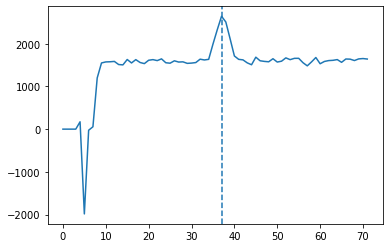

Peak location is at px 37


In [11]:
#calculate the mid point of the bounding box in the dispersion direction
bb = sp2[0].meta.wcs.bounding_box
bb_mid = int(np.round((sp2[0].meta.wcs.bounding_box[1][1] - sp2[0].meta.wcs.bounding_box[1][0]) / 2.))

#trace = imsub[0, bb_mid, :]
trace = sp2[0].data[0, bb_mid, :]
pk_loc = np.argmax(trace)

plt.figure()
plt.plot(trace)
plt.axvline(pk_loc, linestyle='--')
plt.show()
print('Peak location is at px {0}'.format(pk_loc))

As part of the extraction procedure we also apply the aperture correction. This accounts for the flux loss as a function of extraction width and wavelength (no slit losses as this mode is slitless). The steps for this are:
* retrieve the reference file and load as datamodel
* perform a 2D interpolation to get a vector of aperture correction values for the extraction width and the wavelwengths in lam_vec

In [12]:
apcorr_file = 'jwst_miri_apcorr_0007.fits'

# retrieve this file
basename = crds.core.config.pop_crds_uri(apcorr_file)
filepath = crds.locate_file(basename, "jwst")
acref =  datamodels.open(filepath)

2021-04-02 19:32:23,927 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



(388,)
(388,)


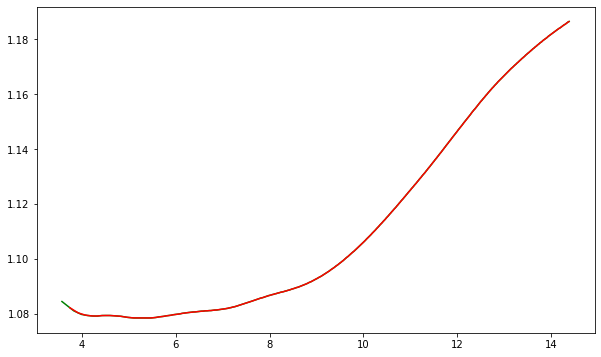

In [13]:
# check that list item 1 is for slitlessprism
ind = 1
assert acref.apcorr_table[ind]['subarray']=='SLITLESSPRISM', "index does not correspond to the correct subarray!"

# first identify where the aperture width is in the "size" array
size_ind = np.argwhere(acref.apcorr_table[ind]['size'] == xwidth)

# take the vector from the apcorr_table at this location and extract. 
apcorr_vec = acref.apcorr_table[1]['apcorr'][:,size_ind[0][0]]
print(np.shape(apcorr_vec))
print(np.shape(acref.apcorr_table[1]['wavelength']))

# now we create an interpolated vector of values corresponding to the lam_vec wavelengths. 
# NOTE: the wavelengths are running in descending order so make sure assume_sorted = FALSE
intp_ac = interp1d(acref.apcorr_table[1]['wavelength'], apcorr_vec, assume_sorted=False)
iapcorr = intp_ac(lam_vec)


plt.figure(figsize=[10,6])
plt.plot(acref.apcorr_table[1]['wavelength'], apcorr_vec, 'g-', label='ref file')
plt.plot(lam_vec, iapcorr, 'r-', label='interpolated')
#plt.plot(lam_vec, ac_vals, 'r-', label='aperture corrections for {} px ap'.format(xwidth))
plt.show()

In [14]:
xwidth_half = int(np.ceil(xwidth / 2))
print('Half width for extraction = {0} px'.format(xwidth_half))

x1ds = []

# calculate the pixel area in sr
pix_scale = 0.11 * u.arcsec
pixar_as2 = pix_scale**2
pixar_sr = pixar_as2.to(u.sr)



# now convert flux from MJy/sr to Jy using the pixel area, and apply the aperture correction
for i in range(sp2[0].meta.exposure.nints):
    x1d_2d = sp2[0].data[i, 6:397, 32:43]
    x1d = np.sum(x1d_2d, axis=1)
    if (sp2[0].meta.bunit_data == 'MJy/sr'):
        x1d_cal = x1d * pixar_sr.value * 1e6 * iapcorr
    x1ds.append(x1d_cal)

print(len(x1ds))

2021-04-02 19:32:24,026 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Half width for extraction = 6 px
10


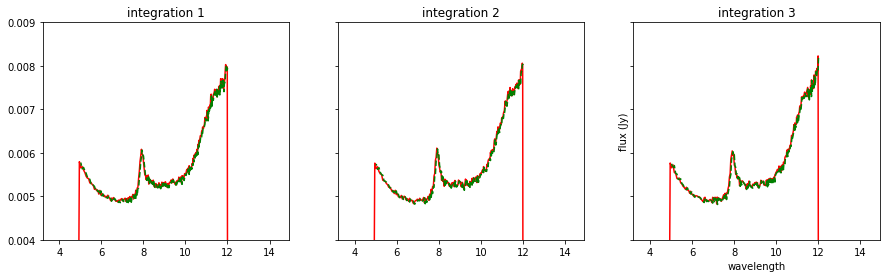

In [15]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=[15,4], sharex='col', sharey='row')
plt.xlabel('wavelength')
plt.ylabel('flux (Jy)')
plt.ylim([0.004, 0.009])
# plot just the first 3 integrations for quick visual inspection:
for i in range(3):
    ax[i].plot(lam_vec, x1ds[i], 'r-', label='manual cal')
    ax[i].plot(x1d_pipe.spec[i].spec_table['WAVELENGTH'],x1d_pipe.spec[i].spec_table['FLUX'], 'g--', label='pipe cal'.format(i))
    ax[i].set_title('integration {0}'.format(i+1))
fig.show()

Now we interpolate the manually extracted spectrum onto the pipeline-generated wavelength grid so we can compare them numerically.

**We compute the percentage difference between the 2 and assert the mean of this difderence between 5 and 12 micron is <= 1 percent. If this next block passes without error, the test is successful.**

2021-04-02 19:32:24,222 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



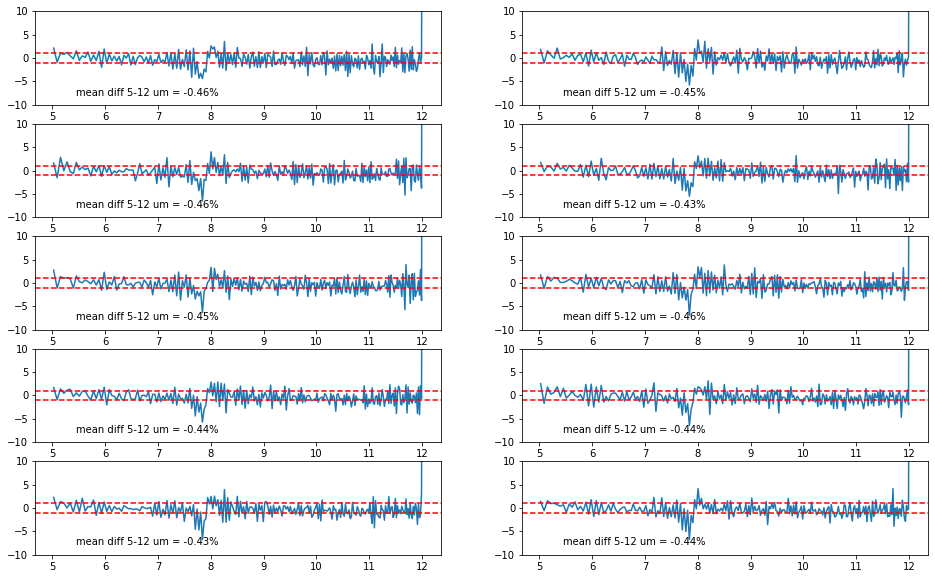

In [16]:
fig = plt.figure(figsize=[16,10])

diffs = []

for ii, xx in enumerate(x1ds):
    plti = ii+1
    ax = fig.add_subplot(5, 2, plti)
    f = interp1d(lam_vec, xx, kind='linear', fill_value='extrapolate')
    ixsub_cal = f(x1d_pipe.spec[ii].spec_table['WAVELENGTH'])
    diff = ((x1d_pipe.spec[ii].spec_table['FLUX'] - ixsub_cal) / x1d_pipe.spec[ii].spec_table['FLUX']) * 100.
    ax.plot(x1d_pipe.spec[ii].spec_table['WAVELENGTH'], diff, label='int {0}'.format(plti))
    ax.axhline(y=1.0, xmin=0., xmax=1., color='r', ls='--')
    ax.axhline(y=-1.0, xmin=0., xmax=1., color='r', ls='--')
    ax.set_ylim([-10., 10])
    
    inds = (x1d_pipe.spec[ii].spec_table['WAVELENGTH'] >= 5.0) & (x1d_pipe.spec[ii].spec_table['WAVELENGTH'] <= 12.)
    ax.annotate('mean diff 5-12 um = {:.2f}%'.format(np.mean(diff[inds])), xy=(0.1, 0.1), xycoords='axes fraction')
    assert np.mean(diff[inds]) <= 1.0, "Mean difference between pipeline and manual extraction >= 1 per cent in 5-12 um. CHECK."   

* Authors: B. Sargent/S. Kendrew, MIRI branch
* Last updated: Feb 4th, 2021